# Задача №1 — семантический текстовый поиск

Команда проекта **"НейроЭмоции"** (MIFIML):
1. Бикбулатова Айгуль Ришатовна.
2. Борзунов Антон Андреевич.
3. Булахов Юрий Эдуардович.
4. Ворошнина Анна Олеговна.
5. Голунов Артем Сергеевич.
6. Ситёв Роман Рустамович.
7. Чунарев Дмитрий Дмитриевич.

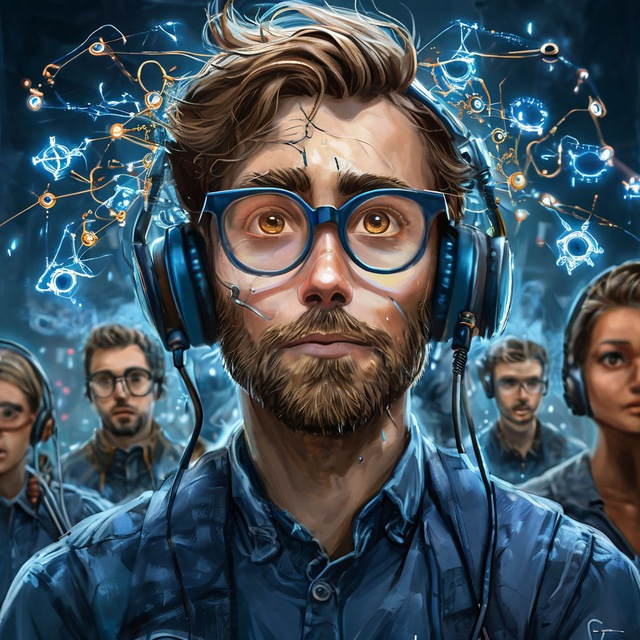

**Цель и ожидаемый результат**

Создать систему семантического текстового поиска слов (словосочетаний) в документах, учитывающую не только точное написание, но и смысловое значение.
Результатом должно быть определение позиции найденного слова/словосочетания в тексте и оценка вероятности совпадения. Желательно реализовать примитивный веб-интерфейс (UI) для ручного тестирования.

**Технические требования**
- Кодовая база на языке Python;
- все тексты только на русском языке в нижнем регистре без пунктуации;
- максимальная длина документа – 30 слов;
- словосочетание состоит не более чем из 2 слов в базовой форме.
- примеры работы программы прилагаются
- время отработки документа на GPU не более 0.5 сек
- объем занимаемой видеопамяти не более 5 Гб

**Критерии оценки**

- PEP8-оформление, docstrings;

- Оформление проекта по шаблону (например, cookiecutter);

- Документация этапов: подготовка данных, обучение, валидация, эксплуатация;

- Возможность запуска через CLI и предпочтительно через Docker;

- requirements.txt с четким списком библиотек и их версий;

- Инструкция по созданию собственного датасета;

- Метрики качества (доля пропусков, ложных срабатываний и др.) с интерпретацией;

- Покрытие кода модульными тестами;

- Информативность экспериментов: какие данные, модели, гиперпараметры, функции ошибки использовались;

***Главный критерий — качество предсказаний на закрытых тестовых данных.***

**Критерии оценки от партнера:**

- Код оформлен в соответствие со стандартом PEP8 (docstring функций, методов, классов);
- Проект организован по шаблону, например cookiecutter;
- Основные этапы проекта (подготовка данных, обучение, валидация, эксплуатация) задокументированы, и их запуск возможен через CLI;
- Предпочтителен запуск проекта через docker контейнер;
- Задан четкий список необходимых библиотек и фреймворков с их версиями (requirements.txt)
- Документация по созданию своего датасета для применения в проекте;
- Разнообразие метрик оценки предсказаний (доля пропусков, доля ложных срабатываний и т.д.);
- Предоставление описаний метрик. Как интерпретировать каждую метрику.
- Покрытие кода модульными тестами;
- Информативность экспериментов по обучению и валидации. Какие были использованы данные, гиперпараметры, модели, функции ошибки и всё, что повлияло на полученные метрики эксперимента;
- Наилучшие метрики на закрытых тестовых данных (едины для всех команд).

**1. Исследование и лингвистическая обработка**

In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
import os
import re
from collections import Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

# Загружаем инструменты NLP для великого и могучего русского языка (оставляем только Natasha, пробовал Stanza и Pullenti, получилась ерунда)
!pip install natasha razdel
from natasha import (
    Doc,
    MorphVocab,
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger
)

# Инициализация компонентов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

# Стоп-слова (Флюгегехаймен)
russian_stopwords = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а',
    'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же',
    'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от',
    'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже',
    'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него',
    'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом',
    'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо',
    'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без',
    'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда',
    'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним',
    'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас',
    'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец',
    'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через',
    'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три',
    'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда',
    'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда',
    'конечно', 'всю', 'между'
]

social_stopwords = ['http', 'https', 'com', 'www', 't.me', 'youtu.be', 'vk.cc', 'ссылка', 'прикреплённые', '🔗']
russian_stopwords.extend(social_stopwords)

In [2]:
# Загружем все файлы, любезно предоставленные компанией Норси-Транс
data_path = 'data/'
dfs = [pd.read_csv(f'{data_path}{i}.csv') for i in range(1, 7)]

# Объединяем все датасеты
data = pd.concat(dfs, ignore_index=True)

In [3]:
# Проверяем структуру данных
print(f"Всего записей: {len(data)}")
print("\nПервые 5 записей:")
display(data.head())

Всего записей: 6000

Первые 5 записей:


,doc_text,image2text,speech2text
0,Твой лучший секс спрятан здесь 🔞 Делюсь канал...,NaN,NaN
1,⭐️ Кнопка: ⭐️START⭐️(https://t.me/major/start...,NaN,NaN
2,А продолжение где? Правильно. В моем сообществ...,девчонки не умеют переписываться sanille они э...,NaN
3,Тем временем моя авторская телега уверенно в т...,10:42 nuil пул telegram ^ 51 142 подписчика 12...,NaN
4,"У меня есть двоюродная сестра, у нее есть сын ...","т с не ^ е z 8 * \""8 ничего не знала о стендап...",NaN


In [4]:
print("\nИнформация об объедииненном датасете:")
display(data.info())  # Проверим на пропущенные значения
print("\nПропущенные значения по колонкам:")
display(data.isnull().sum())


Информация об объедииненном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     6000 non-null   object
 1   image2text   3420 non-null   object
 2   speech2text  1871 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


None


Пропущенные значения по колонкам:


doc_text          0
image2text     2580
speech2text    4129
dtype: int64

In [5]:
# Проверим на пустые строки
print("\nПустые строки по колонкам:")
display(data.apply(lambda x: x.str.strip().eq('')).sum())


Пустые строки по колонкам:


doc_text       0
image2text     0
speech2text    0
dtype: int64

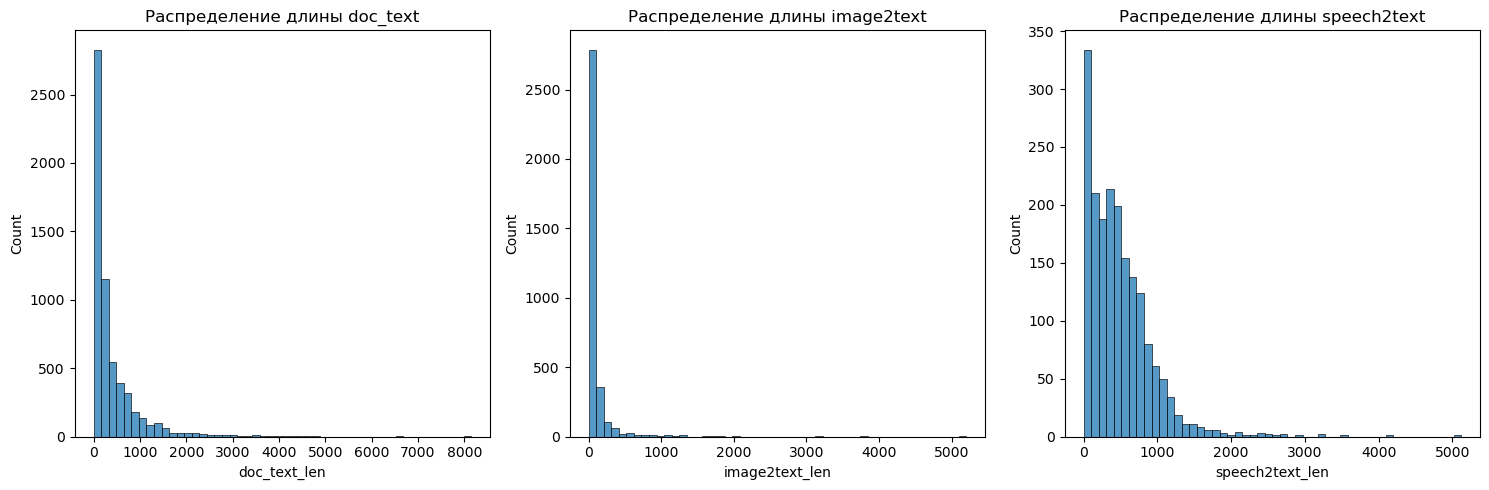

In [6]:
# Проанализируем длину текста
data['doc_text_len'] = data['doc_text'].str.len()
data['image2text_len'] = data['image2text'].str.len()
data['speech2text_len'] = data['speech2text'].str.len()

# Посмотрим на графике
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['doc_text_len'].dropna(), bins=50)
plt.title('Распределение длины doc_text')

plt.subplot(1, 3, 2)
sns.histplot(data['image2text_len'].dropna(), bins=50)
plt.title('Распределение длины image2text')

plt.subplot(1, 3, 3)
sns.histplot(data['speech2text_len'].dropna(), bins=50)
plt.title('Распределение длины speech2text')

plt.tight_layout()
plt.show()

In [7]:
# Почистим данные
def clean_text(text):
    if pd.isna(text) or text.strip() == '':
        return np.nan

    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+\.(com|ru|net|org)\S*', '', text)

    # Удаление специальных символов и эмодзи
    text = re.sub(r'[^\w\s]|[\U00010000-\U0010ffff]', ' ', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text if text != '' else np.nan

# Применение очистки ко всем текстовым колонкам
data['doc_text_clean'] = data['doc_text'].apply(clean_text)
data['image2text_clean'] = data['image2text'].apply(clean_text)
data['speech2text_clean'] = data['speech2text'].apply(clean_text)

# Удалим полностью пустые строчки
initial_count = len(data)
data = data.dropna(how='all', subset=['doc_text_clean', 'image2text_clean', 'speech2text_clean'])
print(f"\nУдалено полностью пустых записей: {initial_count - len(data)}")

# Проверим дубликаты
print("\nКоличество дубликатов по колонкам:")
display(pd.DataFrame({
    'doc_text': [data.duplicated(subset=['doc_text_clean']).sum()],
    'image2text': [data.duplicated(subset=['image2text_clean']).sum()],
    'speech2text': [data.duplicated(subset=['speech2text_clean']).sum()]
}))

# Удалим дубликаты
data = data.drop_duplicates(subset=['doc_text_clean'], keep='first')
data = data.drop_duplicates(subset=['image2text_clean'], keep='first')
data = data.drop_duplicates(subset=['speech2text_clean'], keep='first')
print(f"\nОсталось записей после удаления дубликатов: {len(data)}")


Удалено полностью пустых записей: 28

Количество дубликатов по колонкам:


,doc_text,image2text,speech2text
0,681,3198,4293



Осталось записей после удаления дубликатов: 961


In [8]:
# Предварительная обработка
def preprocess_text(text):
    """Функция предобработки текста с использованием Натали"""
    if pd.isna(text):
        return np.nan

    text = str(text).lower()
    doc = Doc(text)

    # Сегментация на токены
    doc.segment(segmenter)

    # Морфологический разбор
    doc.tag_morph(morph_tagger)

    # Нормализация
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    # Сбор лемм с фильтрацией
    lemmas = []
    for token in doc.tokens:
        token_text = token.text

        # Пропускаем пунктуацию, стоп-слова и не-слова
        if (token_text in string.punctuation or
            token_text in russian_stopwords or
            not token_text.isalpha()):
            continue

        lemmas.append(token.lemma)

    return ' '.join(lemmas) if lemmas else np.nan

# Применяем обработку к текстовым колонкам
text_columns = ['doc_text_clean', 'image2text_clean', 'speech2text_clean']
for col in text_columns:
    processed_col = col.replace('_clean', '_processed')
    data[processed_col] = data[col].progress_apply(preprocess_text)

# Удалим полностью пустые записи
data = data.dropna(
    how='all',
    subset=['doc_text_processed', 'image2text_processed', 'speech2text_processed']
)

print(f"\nОсталось записей после обработки: {len(data)}")

100%|███████████████████████████████████████████████████████████████████████████████| 961/961 [00:08<00:00, 117.95it/s]


Осталось записей после обработки: 961



Топ-30 слов в doc_text:
[('это', 264), ('стендап', 242), ('который', 142), ('человек', 122), ('год', 114), ('новый', 113), ('наш', 112), ('свой', 111), ('мой', 85), ('женский', 82), ('тнт', 77), ('весь', 76), ('смотреть', 75), ('матч', 75), ('россия', 74), ('выпуск', 72), ('видео', 71), ('такой', 70), ('самый', 66), ('день', 63), ('канал', 58), ('каждый', 55), ('один', 53), ('ваш', 53), ('мочь', 51), ('сегодня', 51), ('полный', 50), ('хотеть', 50), ('очень', 49), ('ребенок', 49)]

Топ-30 слов в image2text:
[('v', 50), ('видео', 49), ('м', 36), ('w', 33), ('это', 29), ('е', 28), ('т', 27), ('х', 27), ('эксклюзивно', 25), ('эфир', 22), ('i', 21), ('прямой', 21), ('th', 20), ('tht', 19), ('n', 18), ('s', 18), ('l', 18), ('мой', 16), ('подруга', 16), ('r', 15), ('п', 15), ('з', 14), ('вопрос', 14), ('вообще', 13), ('город', 13), ('winline', 13), ('смотреть', 12), ('полный', 12), ('г', 12), ('матч', 12)]

Топ-30 слов в speech2text:
[('это', 1314), ('говорить', 344), ('такой', 341), ('котор

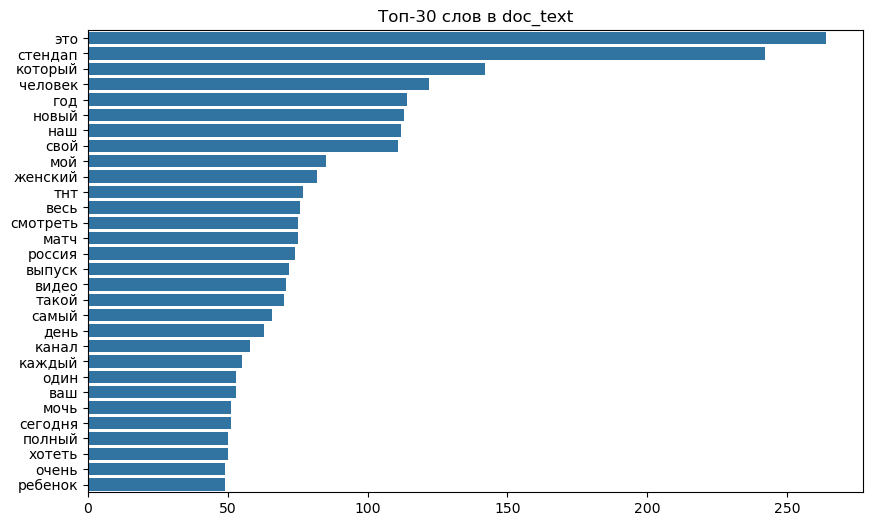

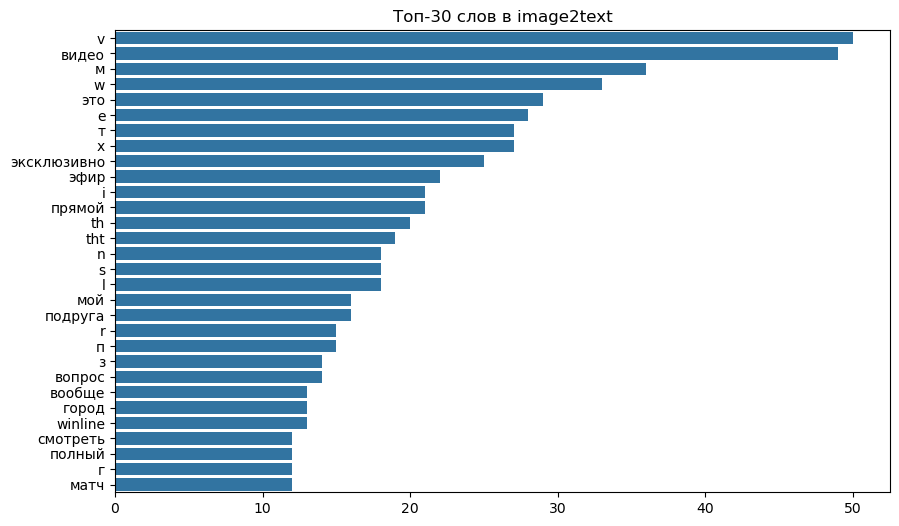

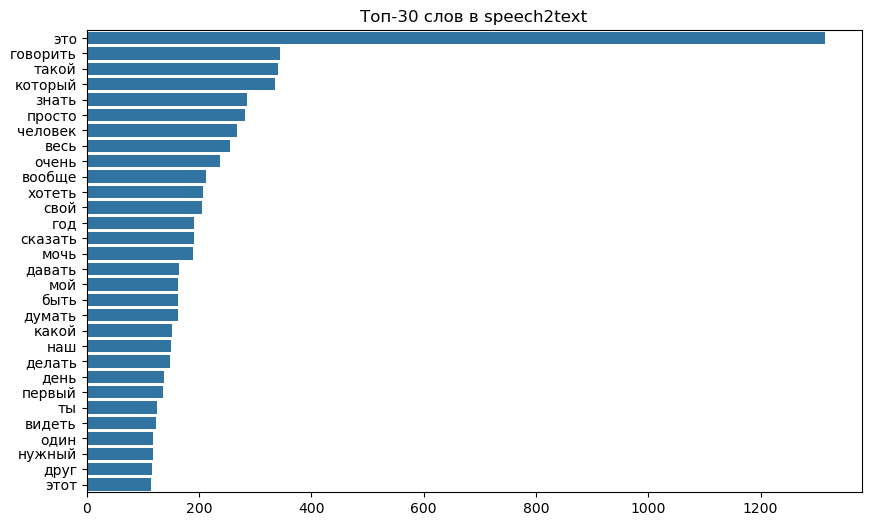

In [9]:
# Проанализируем частоту слов
def get_word_freq(series):
    all_words = []
    for text in series.dropna():
        all_words.extend(text.split())
    return Counter(all_words)

# Частота слов в каждой колонке
doc_word_freq = get_word_freq(data['doc_text_processed'])
image_word_freq = get_word_freq(data['image2text_processed'])
speech_word_freq = get_word_freq(data['speech2text_processed'])

# Топ-30 слов в каждой колонке
print("\nТоп-30 слов в doc_text:")
print(doc_word_freq.most_common(30))

print("\nТоп-30 слов в image2text:")
print(image_word_freq.most_common(30))

print("\nТоп-30 слов в speech2text:")
print(speech_word_freq.most_common(30))

# Посмотрим на графике
def plot_top_words(word_freq, title):
    top_words = word_freq.most_common(30)
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_words(doc_word_freq, 'Топ-30 слов в doc_text')
plot_top_words(image_word_freq, 'Топ-30 слов в image2text')
plot_top_words(speech_word_freq, 'Топ-30 слов в speech2text')

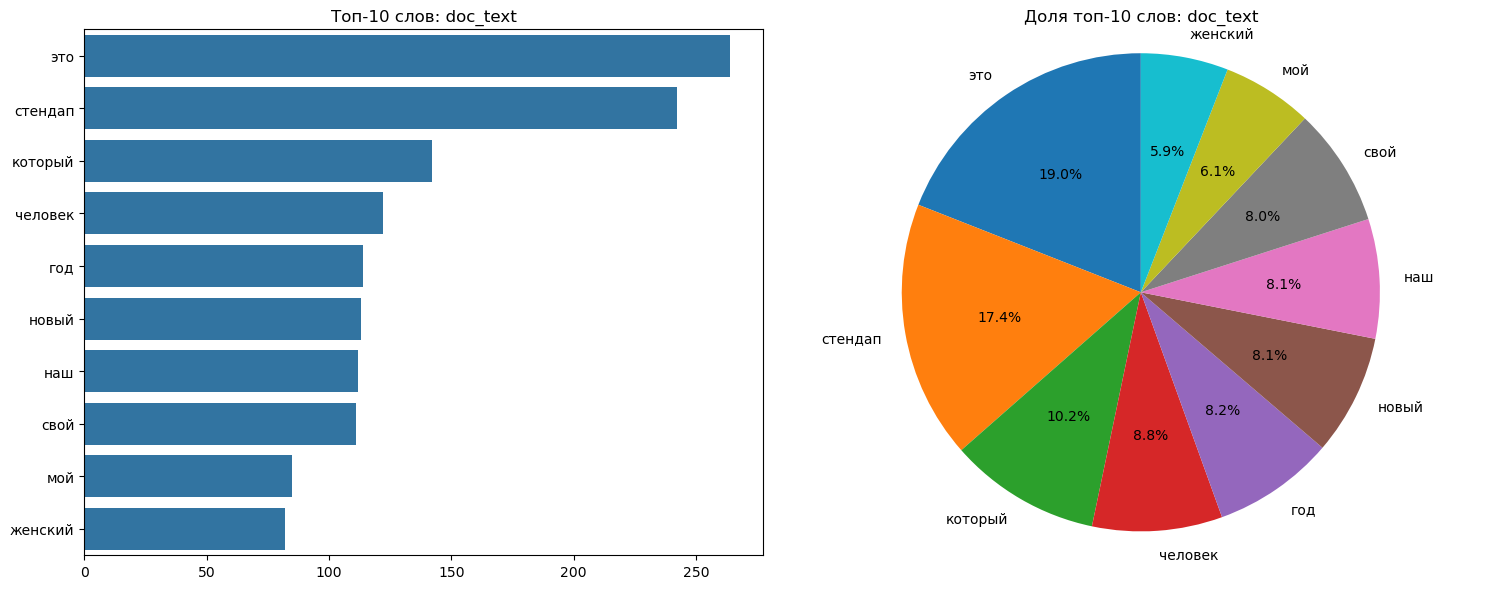

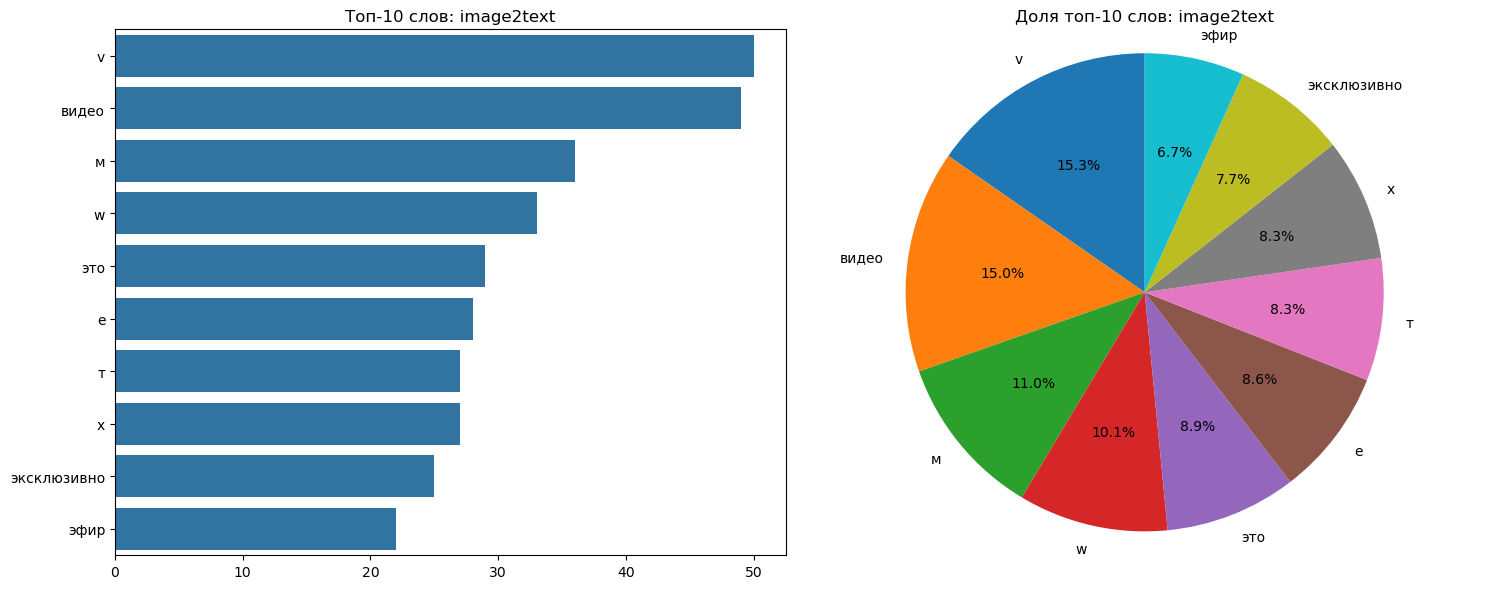

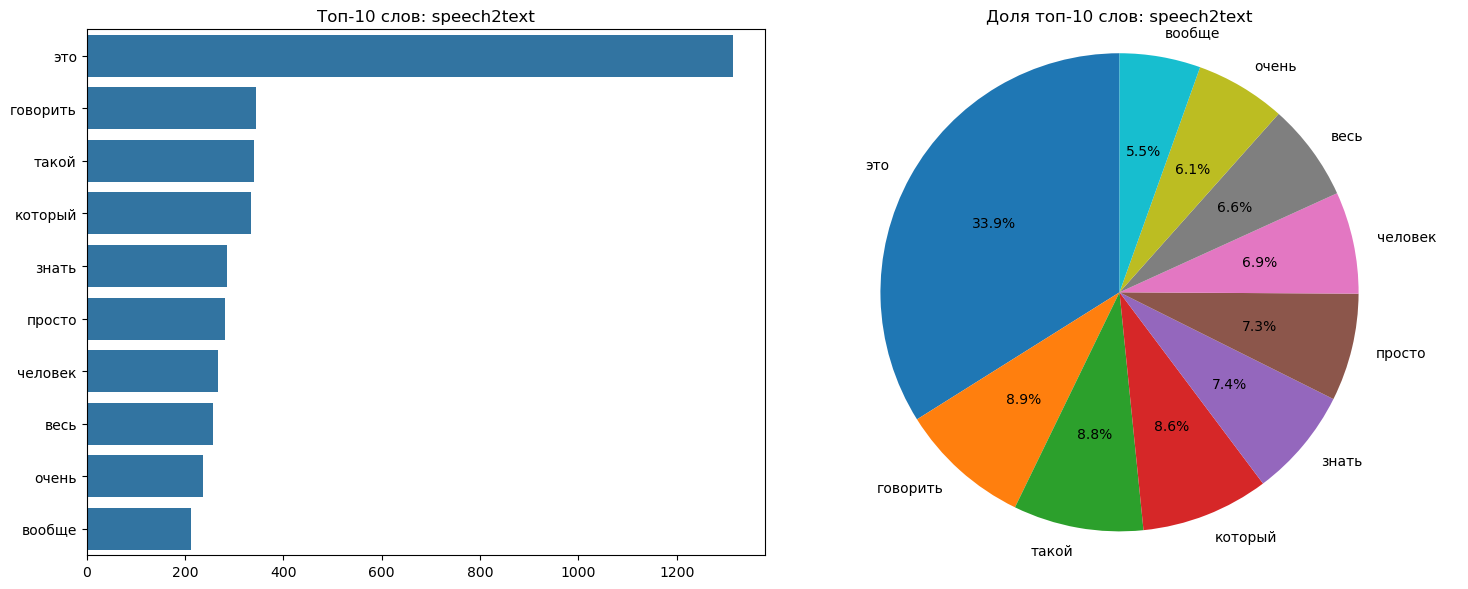

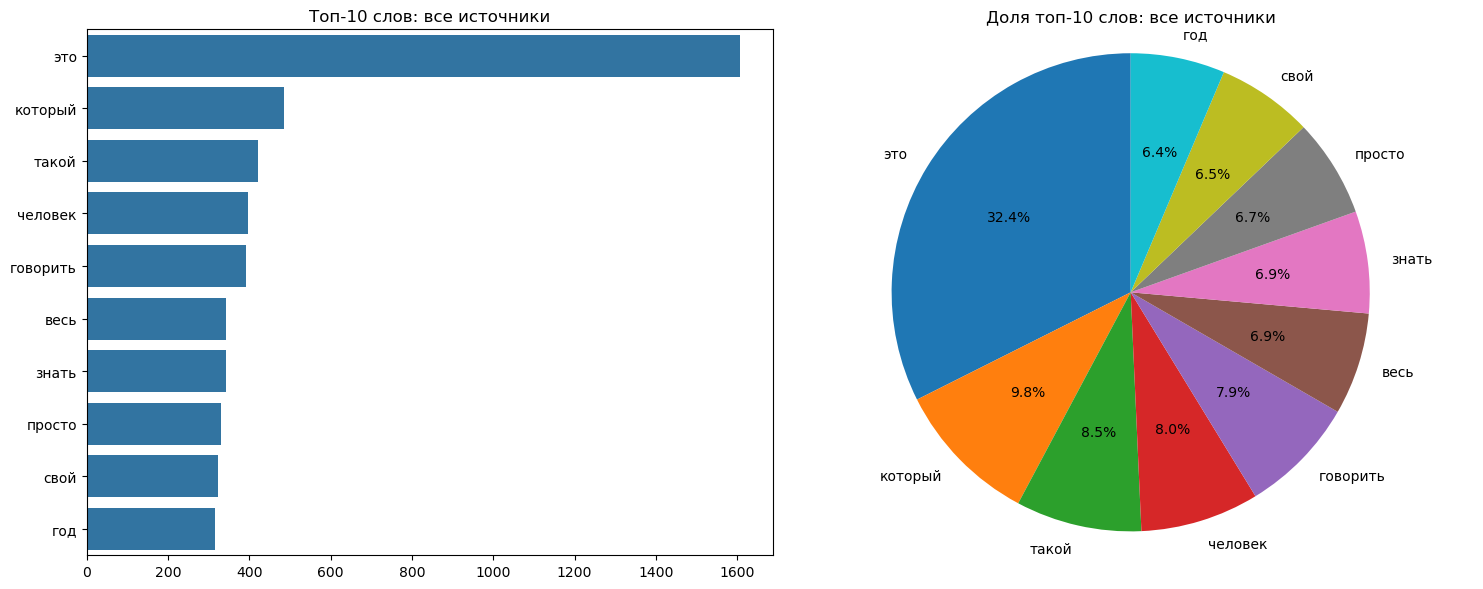

In [11]:
# Посмотрим поподробнее на ТОП-10
def plot_word_stats(word_freq, title):
    top_words = word_freq.most_common(10)
    words, counts = zip(*top_words)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Топ-10 слов: {title}')
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=words, autopct='%1.1f%%', startangle=90)
    plt.title(f'Доля топ-10 слов: {title}')
    plt.axis('equal')  # Чтобы диаграмма была круглой
    plt.tight_layout()
    plt.show()

# Построим графики
plot_word_stats(doc_word_freq, 'doc_text')
plot_word_stats(image_word_freq, 'image2text')
plot_word_stats(speech_word_freq, 'speech2text')

# Дополнительно посмотрим объединенную статистику
all_word_freq = doc_word_freq + image_word_freq + speech_word_freq
plot_word_stats(all_word_freq, 'все источники')

In [16]:
# Сохраним наши результаты в новый CSV файл
output_columns = ['doc_text_processed',
                 'image2text_processed',
                 'speech2text_processed']

data[output_columns].to_csv('data/NeuroEmotions_data.csv', index=False, encoding='utf-8-sig', sep=';')
print("\nОбработанные данные сохранены в 'data/NeuroEmotions_data.csv'")


Обработанные данные сохранены в 'data/NeuroEmotions_data.csv'


**2. Тест моделей**

In [17]:
import re
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
#Загрузка модели
model_name = 'sberbank-ai/sbert_large_nlu_ru'
model = SentenceTransformer(model_name)

In [20]:
def semantic_search(document,query, model,threshhold = 0.65):
    # Выделение кандидатов
    words_with_indices = []
    for match in re.finditer(r'\w+',document):
        words_with_indices.append({
            'text':match.group(0),
            'start':match.start(),
            'end': match.end()
        })
    candidates = []
    for i in range(len(words_with_indices)):
        candidates.append(words_with_indices[i])    

    for i in range(len(words_with_indices)-1):
        word1 = words_with_indices[i]
        word2 = words_with_indices[i+1]
        candidates.append({
        'text': f'{word1['text']} {word2['text']}',
        'start': word1['start'],
        'end': word2['end']
        })

    for i in range(len(words_with_indices)-2):
        word1 = words_with_indices[i]
        word2 = words_with_indices[i+1]
        word3 = words_with_indices[i+2]
        candidates.append({
        'text': f'{word1['text']} {word2['text']} {word3['text']}',
        'start': word1['start'],
        'end': word3['end']
        })
    #Получение эмбеддингов
    query_embedding = model.encode(query)
    candidate_texts = [cand['text'] for cand in candidates]
    candidate_embeddings = model.encode(candidate_texts)
    #Вычисление сходства
    similarities = cosine_similarity([query_embedding], candidate_embeddings)[0]
    best_candidate_index = np.argmax(similarities)
    max_similarity = similarities[best_candidate_index]
    best_candidate = candidates[best_candidate_index]
    if max_similarity >= threshhold:
        position_str = f'{best_candidate['start']} - {best_candidate['end']}'
        probability = float(max_similarity)
        return best_candidate, position_str, probability
    else:
        print(f"Макс. сходство {max_similarity:.4f} для '{best_candidate['text']}' не достигло порога {threshold}")
        return None 

In [22]:
# --- Тестирование ---
examples = [
    ("доченька твоя совсем большая стала", "дочь"),
    ("вся дорога забита деревьями и цветами", "дерево"),
    ("в следующее воскресенье я собираюсь в питер", "санкт петербург"),
    ("у меня сломалась стиралка прикинь", "стиральная машина"),
    ("садись в машину и поехали уже", "автомобиль"),
    ("сколько стоит ремонт стиральной машины", "автомобиль"), # Ожидается НЕ найти?
    ("ты когда собираешься звонить преподу", "учитель"),
    ("возьмешь пистолет в тумбочке понял меня", "оружие"),
    ("ты не мог бы набрать меня после обеда", "звонить"),
    ("ты возьми корзину прежде чем набрать продукты", "звонить"), # Ожидается НЕ найти?
    ("его сегодня утром отвезли в ближайший госпиталь", "больница"),
    ("в этому году смартфоны подорожают на 30 процентов", "телефон"),
    ("я еще долгу не смогу вернуться в рф", "россия"),
    ("мужчина средних лет с серым рюкзаком и шапкой", "портфель"),
    ("в какой университет собирается поступать твой сын", "институт"),
    ("он вообще не собирается переезжать в другое государство", "страна"),
    ("сегодня ночью наше судно отплывает по расписанию", "корабль"),
    ("его оригинальный портрет выставлен на продажу", "подлинная картина"),
]
for document, query in examples:
    result = semantic_search(document, query, model, threshhold = 0.6)
    print(f"Документ: '{document}'")
    print(f"Запрос: '{query}'")
    if result:
        best_candidate, position_str, probability = result
        print(f'Результат: Слово - {best_candidate}, Позиция: {position_str}, Вероятность: {probability}')
    else:
        print(f"Для {query} совпадений в документе не найдено")

Документ: 'доченька твоя совсем большая стала'
Запрос: 'дочь'
Результат: Слово - {'text': 'доченька твоя', 'start': 0, 'end': 13}, Позиция: 0 - 13, Вероятность: 0.7896547913551331
Документ: 'вся дорога забита деревьями и цветами'
Запрос: 'дерево'
Результат: Слово - {'text': 'деревьями', 'start': 18, 'end': 27}, Позиция: 18 - 27, Вероятность: 0.6663848161697388
Документ: 'в следующее воскресенье я собираюсь в питер'
Запрос: 'санкт петербург'
Результат: Слово - {'text': 'питер', 'start': 38, 'end': 43}, Позиция: 38 - 43, Вероятность: 0.928465723991394
Документ: 'у меня сломалась стиралка прикинь'
Запрос: 'стиральная машина'
Результат: Слово - {'text': 'стиралка', 'start': 17, 'end': 25}, Позиция: 17 - 25, Вероятность: 0.8822277784347534
Документ: 'садись в машину и поехали уже'
Запрос: 'автомобиль'
Результат: Слово - {'text': 'машину', 'start': 9, 'end': 15}, Позиция: 9 - 15, Вероятность: 0.8909332752227783
Документ: 'сколько стоит ремонт стиральной машины'
Запрос: 'автомобиль'
Результат

**3. Разработка интерфейсов**

**4. Оптимизация**

**5. Упаковка и подготовка документации**

**6. Оформление финальных материалов**